In [4]:
import os

os.getcwd()+'/data'

'/Users/anirudhasarmatumuluri/RUTGERS/3 SEM/ML/mini-project/data'

In [107]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

def get_data(data, indices=None, binarize=True):
    N = len(data)
    if indices is None:
        indices = range(0, N)
    #X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
    X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
    if binarize: X = (X > 0.5)
    #y = torch.tensor([data[i][1] for i in indices])
    y = np.array([data[i][1] for i in indices])
    return X, y

data = datasets.EMNIST(
    root=os.getcwd()+'/data',
    split="balanced",
    download=True,
    transform=data_transform
)

X, y = get_data(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=0)



100%|████████████████████████| 561753746/561753746 [01:04<00:00, 8738761.13it/s]


Extracting /Users/anirudhasarmatumuluri/RUTGERS/3 SEM/ML/mini-project/data/EMNIST/raw/gzip.zip to /Users/anirudhasarmatumuluri/RUTGERS/3 SEM/ML/mini-project/data/EMNIST/raw


# Visualizing the Images

112800


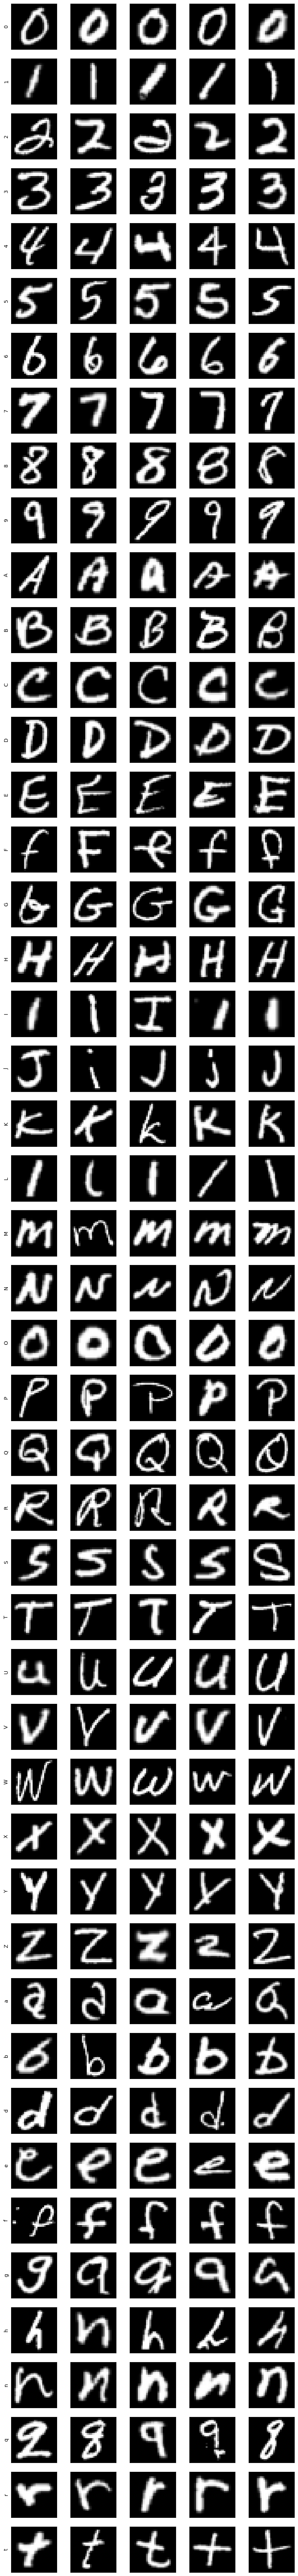

In [62]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline


transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.ToTensor()])
import pandas as pd
training_data = datasets.EMNIST(
    root=os.getcwd()+'/data',
    split="balanced",
    download=True,
    transform=transform
)

samples = [0 for _ in range(47)]

indices = dict()

for i in range(47):
    indices[i] = []
    
for i in range(len(training_data)):
    label = training_data[i][1]
    
    if(samples[label]<5):
        indices[label].append(i)
        samples[label]+=1
    
    if ((len(set(samples))==1) and (5 in samples)):
        break
        
rows = 47
cols = 5

plt.figure(figsize=(10,90))
for i in range(rows):
    for j in range(cols):
#         print(i*cols+j+1)
        plt.subplot(rows,cols,i*cols+j+1)
        plt.imshow(training_data[indices[i][j]][0][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if(j==0):
            plt.ylabel(str(training_data.classes[i]))
        
plt.show()
    
    

In [67]:
training_data[0][0].shape
torch.stack([training_data[i][0] for i in range(len(training_data))]).shape

torch.Size([112800, 1, 28, 28])

In [103]:
size = 500
C = 47
subtrain = torch.stack([training_data[i][0] for i in range(size)])
subtrain_labels = torch.tensor([training_data[i][1] for i in range(size)])
print(subtrain.shape)

torch.Size([500, 1, 28, 28])


In [93]:
class_priors = torch.zeros(C)
for i in range(len(subtrain)):
    class_priors[subtrain_labels[i]]+=1

class_priors /= size
class_priors  

tensor([0.0200, 0.0160, 0.0260, 0.0300, 0.0320, 0.0140, 0.0140, 0.0180, 0.0240,
        0.0260, 0.0260, 0.0260, 0.0300, 0.0160, 0.0220, 0.0260, 0.0240, 0.0240,
        0.0220, 0.0160, 0.0320, 0.0140, 0.0120, 0.0180, 0.0160, 0.0300, 0.0140,
        0.0180, 0.0180, 0.0180, 0.0260, 0.0260, 0.0240, 0.0180, 0.0200, 0.0260,
        0.0200, 0.0120, 0.0260, 0.0200, 0.0240, 0.0140, 0.0140, 0.0200, 0.0140,
        0.0280, 0.0260])

In [155]:
pixel_priors = torch.zeros((C,28,28))

for i in range(len(subtrain)):
    for j in range(28):
        for k in range(28):
            if subtrain[i][0][j][k]>0:
                pixel_priors[subtrain_labels[i],j,k]+=1

pixel_priors+=1
pixel_priors/=size
# theta_denominators = subtrain_labels.unique(return_counts=True)[1]
# for i in range(C):
#     pixel_priors[i] = pixel_priors[i]/theta_denominators[i]
# print(pixel_priors)
# for i in range(C):
#     plt.figure(figsize=(2,2))
#     plt.imshow(pixel_priors[i])
#     plt.show()

In [159]:
test_id = 101
testimg = training_data[test_id][0]
testimg = testimg[0]

probs = torch.log(class_priors)

for i in range(28):
    for j in range(28):
        for c in range(C):
            if testimg[i][j]==0:
                probs[c]+=torch.log(1-pixel_priors[c][i][j])
            else:
                probs[c]+=torch.log(pixel_priors[c][i][j])

print(training_data.classes[np.argmax(probs)], training_data.classes[training_data[test_id][1]])

3 h


# Building the Methods

## MLE

In [11]:
from sklearn.base import BaseEstimator

class MLE(BaseEstimator):
    
    def __init__(self, C):
        self.C = C
        self.class_priors = torch.zeros(C)
        self.pixel_priors = torch.zeros((C,28,28))
        
        
    def fit(self, X, y):
        # Calculate class_priors
        class_priors = torch.zeros(C)
        for i in range(len(y)):
            class_priors[y[i]]+=1
        class_priors /= len(y)
        
        # Calculate pixel_priors
        pixel_priors = torch.zeros((C,28,28))
        for i in range(len(y)):
            for j in range(28):
                for k in range(28):
                    if X[i][0][j][k]>0:
                        pixel_priors[y[i],j,k]+=1

        pixel_priors+=1
        pixel_priors/=len(y)
        
        return self
    
    def predict(self, X):
        ans = []
        return ans
    
    def score(self, X, y):
        # Something along the lines of use preict and then calculate score
        ans = 0
        return ans
        

## MAP

In [ ]:
from sklearn.base import BaseEstimator

class MAP(BaseEstimator):
    
    def __init__(self, placeholder):
        self.placeholder = placeholder
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        ans = []
        return ans
    
    def score(self, X, y):
        # Something along the lines of use preict and then calculate score
        ans = 0
        return ans
        